## Image classification with Torch
			
### Part 1. Data loading and manipulation 
The project was performed as an assigment in ML and Artificial Intelligence course at the University of Sheffield.
[**CIFAR-10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton from the University of Toronto. 

1a. **Download** the training and test data of the CIFAR-10 dataset <br>
1b. **Add random noise** to all training and test data to generate noisy dataset<br>
1c. **Extract a subset** "CatDog" which consists of only two classes: **Cat** and **Dog**.       
1d. Show 10 pairs of original and noisy images of cats and dogs.<br>

### Part 2: Dimensionality reduction, binary classification, and evaluation 
**Training:**

2a. Apply PCA on the training set to reduce the dimensionality.<br> 
2b. Train eight Naive Bayes classifiers: one on the original features (raw pixels), and seven on the seven different PCA features in 2a. 

**Testing and evaluation:**

2c. Evaluate the eight Naive Bayes classifiers on the test set in terms of classification accuracy.<br>
2d. Plot the ROC Curves in true positive rates vs false positive rates for the eight Naive Bayes classifiers.<br>
2e. Compute the area under the ROC curve values for the eight Naive Bayes classifiers and visualise using a bar graph.

### Part 3: Multiclass classification of Noisy **CatDog** subset.

3a. Repeat 2a, 2b, and 2c on the noisy version of CatDog subset.<br> 
3b. Apply PCA on the training set to reduce the dimensionality.<br> 
3c. Train nine classifers: 
- **four Naive Bayes** classifiers(one on the original features and three on the three different PCA features in 3b); 
- **four Logistic Regression** classifiers (one on the original features, and three on the three different PCA features in 3b); 
- one **Convoluational Neural Network** as defined in the [pytorch CIFAR10 tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

3d. Evaluate the nine classifiers on the test set in terms of **classification accuracy**, **total training time**, and **total test time**.<br>
3e. Show the confusion matrix for these nine classifiers

### Part 4: Multiclass classification using the original CIFAR-10 dataset (all 10 classes), Denoising Autoencoder 

4a. Modify the autoencoder architecture in Lab 7 so that it takes colour images as input (i.e., 3 input channels).

4b. Training: 
- feed the noisy training images as input to the autoencoder in 4a; 
- use a loss function that computes the reconstruction error between the output of the autoencoder and the respective original images.

4c. Testing: 
- evaluate the autoencoder trained in 4b on the test datasets (feed noisy images in and compute reconstruction errors on original clean images. 
 - find the worstly denoised 30 images (those with the largest reconstruction errors) in the test set and show them in pairs with the original images (60 images to show in total).

4d. Choose at least two hyperparameters to vary. When varying one hyperparameter, all the other hyperparameters can be fixed. Visualise the performance sensitivity with respect to these hyperparameters.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
import torch.optim as optim

import heapq

#### Question 1 Answer

In [3]:
UCard_number = 1715791
torch.manual_seed(UCard_number)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()
    
def add_noise_img(image, scale):
    image_tensor = image + scale * torch.randn(image.shape)
    image_tensor_norm = torch.clamp(image_tensor, 0., 1.)
    return image_tensor_norm

# https://discuss.pytorch.org/t/how-to-add-noise-to-inputs-as-a-function-of-input/54839/2

In [5]:
# 1a - Original dataset

batchSize=8

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# 1b Noisy dataset

noise_scale = 0.2 # we can choose any scale value between 0.2 and 0.5

transform_add_noise = transforms.Compose([transforms.ToTensor(),
                                          transforms.Lambda(lambda x: add_noise_img(x, noise_scale)), 
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset_with_noise = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform = transform_add_noise)
trainloader_with_noise = torch.utils.data.DataLoader(trainset_with_noise, batch_size = batchSize,
                                          shuffle=True, num_workers=2)

testset_with_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform = transform_add_noise)

testloader_with_noise = torch.utils.data.DataLoader(testset_with_noise, batch_size = batchSize,
                                          shuffle=True, num_workers=2)

Original pictures:


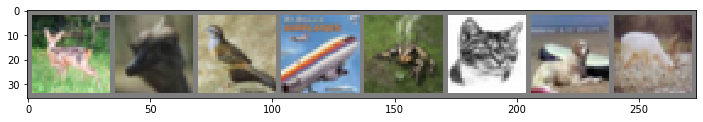

 ship       bird       bird       frog        cat        car       deer      truck
Pictures with Noise:


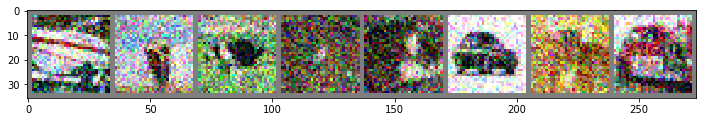

 ship       bird       bird       frog        cat        car       deer      truck


In [8]:
# Checking noisy data
dataiter_train = iter(trainloader)
images_train, labels_train = dataiter_train.next()

dataiter_with_noise_train = iter(trainloader_with_noise)
images_with_noise_train, labels_with_noise_train = dataiter_with_noise_train.next()

plt.figure(figsize=(12,6))
print('Original pictures:')
imshow(torchvision.utils.make_grid(images_train));
# print labels
print('      '.join('%5s' % classes[labels_with_noise_train[j]] for j in range(batchSize)))

print('Pictures with Noise:')
plt.figure(figsize=(12,6))
imshow(torchvision.utils.make_grid(images_with_noise_train));
# print labels
print('      '.join('%5s' % classes[labels_with_noise_train[j]] for j in range(batchSize)))

In [9]:
# 1c - subsets with only Cat and Dogs

cat_dog_indices_train = [index for index, data in enumerate(trainset) if (data[1] == 3) | (data[1] == 5)]
CatDog_subset_train =  torch.utils.data.Subset(trainset, cat_dog_indices_train)
CatDog_trainloader = torch.utils.data.DataLoader(CatDog_subset_train, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

cat_dog_indices_test = [index for index, data in enumerate(testset) if (data[1] == 3) | (data[1] == 5)]
CatDog_subset_test =  torch.utils.data.Subset(testset, cat_dog_indices_test)
CatDog_testloader = torch.utils.data.DataLoader(CatDog_subset_test, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

CatDog_subset_with_noise_train =  torch.utils.data.Subset(trainset_with_noise, cat_dog_indices_train)
CatDog_subset_with_noise_test =  torch.utils.data.Subset(testset_with_noise, cat_dog_indices_test)

In [10]:
# 1d pairs of original and noisy images of cats and dogs 

cat_indices_train = [index for index, data in enumerate(CatDog_subset_train) if data[1] == 3]
dog_indices_train = [index for index, data in enumerate(CatDog_subset_train) if data[1] == 5]

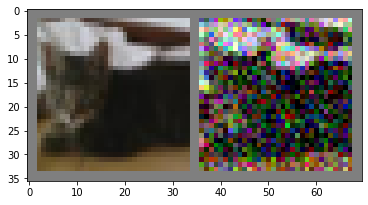

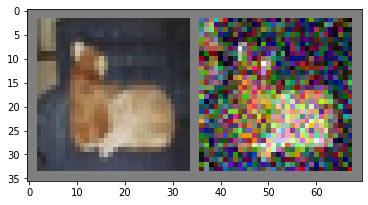

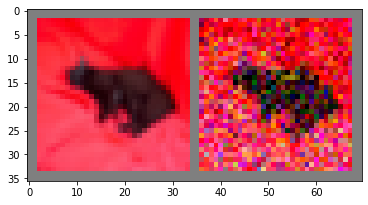

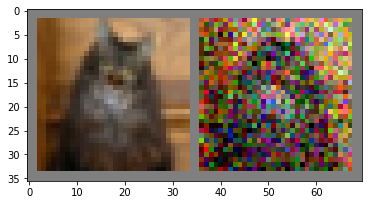

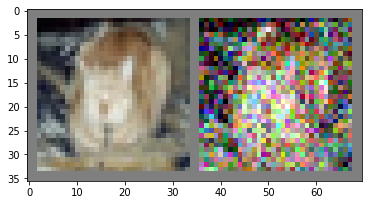

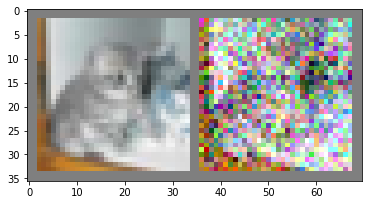

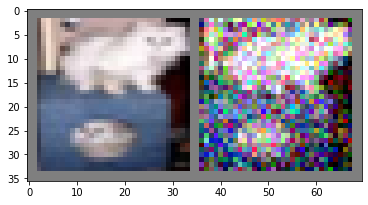

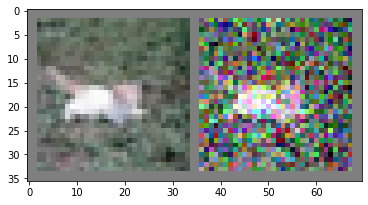

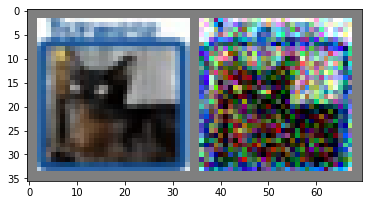

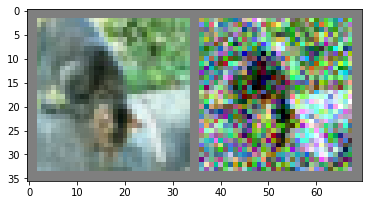

In [11]:
# Pairs of cats - original and noisy images
for index in cat_indices_train[:10]:
    original_noisy = [CatDog_subset_train[index][0], CatDog_subset_with_noise_train[index][0]] 
    imshow(torchvision.utils.make_grid(original_noisy))

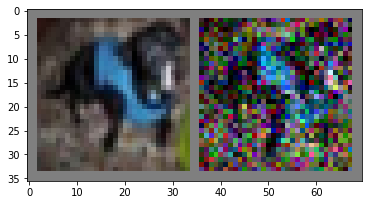

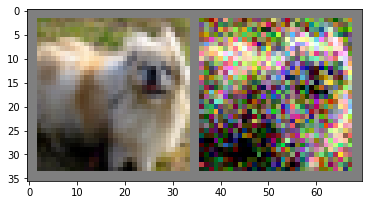

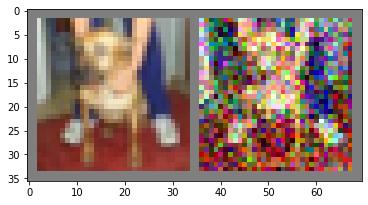

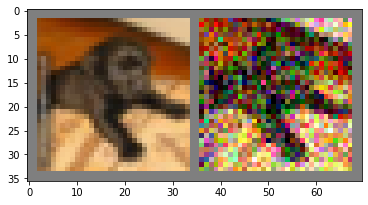

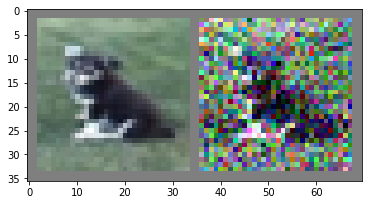

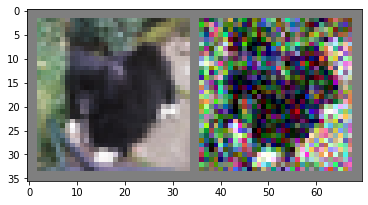

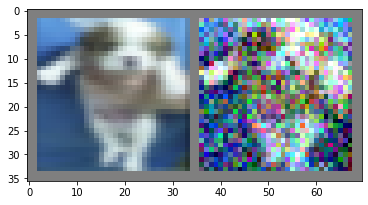

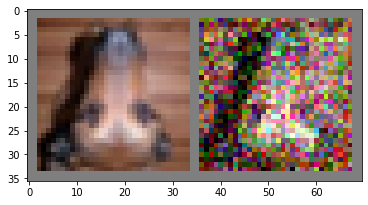

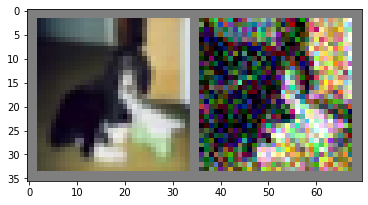

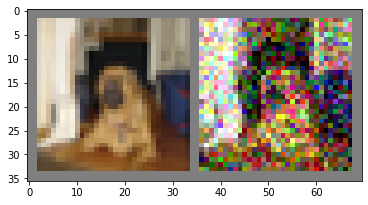

In [12]:
# Pairs of dogs - original and noisy images
for index in dog_indices_train[:10]:
    original_noisy = [CatDog_subset_train[index][0], CatDog_subset_with_noise_train[index][0]] 
    imshow(torchvision.utils.make_grid(original_noisy))

### Part 2: Dimensionality reduction, binary classification, and evaluation

In [14]:
def collect_data(dataset, binarisation_for_cat_dog = False):
    # x = torch.empty([len(dataset), 3, 32, 32])
    tensor_size = [len(dataset)]
    tensor_size.extend(list(dataset[0][0].shape))
    x = torch.empty(tensor_size)
    y = torch.empty(tensor_size[0])
    
    i = 0
    for image, target in dataset:
        x[i] = image
        y[i] = target
        i += 1
    if binarisation_for_cat_dog:
        y[y==3]=0
        y[y==5]=1
        
    return x, y

def convert_data_to_numpy_and_reshape(x,y):
    # Data reshaping for PCA
    x = x.numpy() 
    y = y.numpy()

    # vectorizing each image into single vector with lenth 3*32*32 = 3072
    x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])    
    return x, y

def transform_data_pca(x_train, x_test, n_components, svd_solver = 'randomized', random_state = UCard_number):
    pca_model = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True, random_state = UCard_number)
    x_train_pca_done = pca_model.fit_transform(x_train)
    x_test_pca_done = pca_model.transform(x_test)
    return x_train_pca_done, x_test_pca_done

In [15]:
# Collecting x and y from dataset tuples

x_train, y_train = collect_data(CatDog_subset_train, binarisation_for_cat_dog = True)
x_test, y_test = collect_data(CatDog_subset_test, binarisation_for_cat_dog = True)

# Data reshaping for PCA

x_train_pca, y_train = convert_data_to_numpy_and_reshape(x_train, y_train)
x_test_pca, y_test = convert_data_to_numpy_and_reshape(x_test, y_test)

In [16]:
%%time
# First we train PCA without specified number of principal componets to evaluate variance spread
# PCA with numpy

pca = PCA(svd_solver = 'randomized', random_state = UCard_number)
pca.fit(x_train_pca)

CPU times: user 1min 14s, sys: 1.13 s, total: 1min 15s
Wall time: 41.4 s


PCA(copy=True, iterated_power='auto', n_components=None, random_state=1715791,
    svd_solver='randomized', tol=0.0, whiten=False)

3072 principal components explain 100.00% of variance


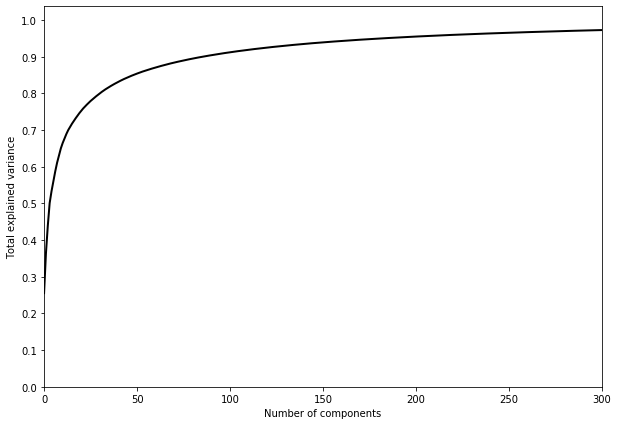

In [17]:
print('%d principal components explain %.2f%% of variance' %
      (pca.n_components_, 100 * np.cumsum(pca.explained_variance_ratio_)[-1]))
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=2, color='k')
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 300)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [18]:
# 2a. 7 values of k (number of PCA componets) were chosen as to capture 
# the following ratios of variance: 0.7, 0.8, 0.85, 0.9, 0.95, 0.97 and 0.99

k1 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.7)[0][1]
k2 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)[0][1]
k3 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.85)[0][1]
k4 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][1]
k5 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][1]
k6 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.97)[0][1]
k7 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][1]

In [19]:
range_k = [0, k1, k2, k3, k4, k5, k6, k7]
range_k

[0, 15, 32, 50, 87, 184, 283, 561]

### Multinomial Naive Bayes Classifier for original data

In [20]:
def train_Bayes_classifier(x_train, y_train, x_test, y_test, model = 'gaussian', scaling = False):
    # some Naive Bayes classifier to be used in further tasks does not want negative values 
    # so we need to get rid of them by using MinMaxScaler
    if  scaling == True:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test= scaler.transform(x_test)
        
    if model == 'gaussian':
        classifier = GaussianNB()
    elif model == 'multinomial':
        classifier = MultinomialNB()
    elif model == 'complement':
        classifier = ComplementNB(100)
    elif model == 'bernoulli':
        classifier = BernoulliNB(100)
    else: 
        print('The model is not found')
    
    classifier.fit(x_train, y_train)
    predicted_labels = classifier.predict(x_test)

    accuracy = accuracy_score(y_test, predicted_labels)
    y_pred_proba = classifier.predict_proba(x_test)[::,1]
    auc = roc_auc_score(y_test, y_pred_proba)
    return accuracy, y_pred_proba, auc

### Accuracies of Naive Bayes Classifier for original data

In [21]:
print('Accuracy for Multinomial Classifier:', train_Bayes_classifier(x_train_pca, y_train, x_test_pca, y_test, model = 'multinomial', scaling = True)[0])
print('Accuracy for Complement Classifier:', train_Bayes_classifier(x_train_pca, y_train, x_test_pca, y_test, model = 'complement', scaling = True)[0]) 
print('Accuracy for Gaussian Classifier:', train_Bayes_classifier(x_train_pca, y_train, x_test_pca, y_test, model = 'gaussian', scaling = False)[0])
print('Accuracy for Bernoulli Classifier:', train_Bayes_classifier(x_train_pca, y_train, x_test_pca, y_test, model = 'bernoulli', scaling = False)[0])

Accuracy for Multinomial Classifier: 0.567
Accuracy for Complement Classifier: 0.5675
Accuracy for Gaussian Classifier: 0.5935
Accuracy for Bernoulli Classifier: 0.594


**2b Explanation of Naive Bayes Classifier Choice**
<br> As it come from the result of classification accuracy, Gaussian Naive Bayes Classifier appears to provide better classification. Partialy it can be explained by the fact that to avoid negative values we have applied MinMaxScalerof the data and therefore introduced some dependencies between the data feeded into Multinomial Classifier.
<br> However, Naive Bayes Classifier supposes data's independence. So from that point of view, Gaussain Classifier uses less subjective data and therefore performs much better.

In [22]:
%%time
accuracies = []
y_predict_probas = []
model_comparison = {}

for k in range_k:
    if k ==0:
        accuracy, y_pred_proba, auc = train_Bayes_classifier(x_train_pca, y_train, 
                                                         x_test_pca, y_test, model = 'gaussian', scaling = False)
        k = "original_data"
    else:
        x_train_pca_done, x_test_pca_done = transform_data_pca(x_train_pca, x_test_pca, n_components= k)

        accuracy, y_pred_proba, auc = train_Bayes_classifier(x_train_pca_done, y_train, 
                                                             x_test_pca_done, y_test, model = 'gaussian', scaling = False)

    model_comparison[str(k)] = {}
    model_comparison[str(k)] = {}
    model_comparison[str(k)]['accuracy'] = accuracy
    model_comparison[str(k)]['y_pred_proba']  = y_pred_proba
    model_comparison[str(k)]['auc'] = auc
    
    accuracies.append(accuracy)
    y_predict_probas.append(y_pred_proba)
    

CPU times: user 31.4 s, sys: 768 ms, total: 32.2 s
Wall time: 16.5 s


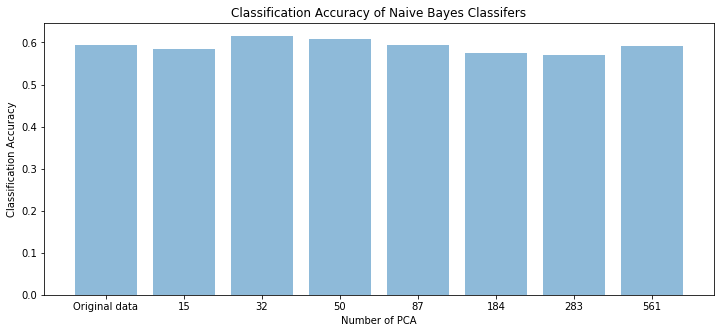

In [23]:
# 2c. comparison of classification accuracy of eight Naive Bayes classifiers on the test set
# and visualisation of their performance using a bar graph

plt.figure(figsize=(12,5))
objects = ('Original data', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))

plt.bar(y_pos, accuracies, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy of Naive Bayes Classifers')

plt.show()

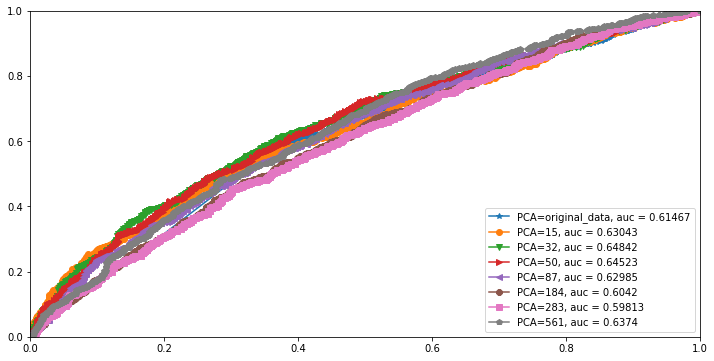

In [24]:
# 2d. Plot the ROC Curves in true positive rates vs false positive rates for the eight Naive Bayes classifiers 


plt.figure(figsize=(12,6))
plot_markers = ['*', 'o', 'v', '>','<', '8', 's', 'p']

auc_values = []
i=0
for model in model_comparison:
    y_pred_proba = model_comparison[model]['y_pred_proba']
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, marker= plot_markers[i], label = 'PCA='+ str(model) +", auc = " + str(round(auc, 5)))
    auc_values.append(auc)
    i += 1
    
plt.xlim((0,1))
plt.ylim((0,1))
plt.legend(loc=4)
plt.show()

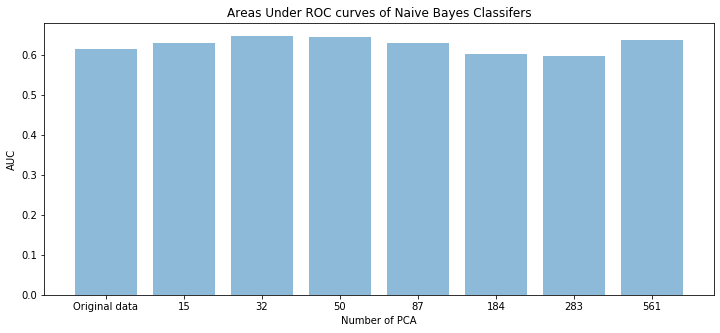

In [25]:
#2e. bar graph with area under the ROC curve values for the studied Naive Bayes classifiers
plt.figure(figsize=(12,5))
objects = ('Original data', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))
plt.bar(y_pos, auc_values, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('AUC')
plt.title('Areas Under ROC curves of Naive Bayes Classifers');

In [26]:
# Gaussian Nayive classifier has appeared to have better perormance than Multinomialthat can

In [27]:
print('Accuracies:', accuracies)
print("AUC values", auc_values)

Accuracies: [0.5935, 0.5855, 0.6155, 0.609, 0.595, 0.5745, 0.5695, 0.5925]
AUC values [0.614666, 0.6304299999999999, 0.648415, 0.6452349999999999, 0.629853, 0.604205, 0.598131, 0.6373989999999999]


In [28]:
(np.array(accuracies).max()- np.array(accuracies).min())/np.array(accuracies).min()

0.08077260755048295

In [29]:
np.array(auc_values).max()- np.array(auc_values).min()

0.050283999999999995

**Interesting observations:** 

1. Gaussian Nayive classifiers have appeared to show almost similar performance evaluated in terms of their accuracies, ROC curves and AUC values regardless diferent TPCA transformations of the CatDog subset. The difference between the best and the worst accuracies and auc values has appeared to be around 0.05. This corresponds to maximum 8% of improvement when we switch from one model to another.

2. Surprisingly, we can find that there is no obvious dependance between number of PCA components that were chosen to capture different ratio of data variance and final performance of Gaussian Nayive classifiers. The best performance appeared to be for 32 and  50 numbers of PCA components, yet they refer neither to minimum or maximum values of studied range. Complementary, it had been reasonable to expect convergence to similar performances of classifiers trained on original data and data that was trasnformed with the highest numebr of PCA that had been chosen to capture 99% of variance in the data.

3. The third observation can be devoted to our satisfaction with Gaussian Nayive classifiers' perormance. For the current CatDog subset, their accuracies and auc values appeared to vary around 0.6. In general, such low results can hardly be improved by changing hyperparameters and playing with validation/cross-validation and other techniques. The most reasonable way in practice is usually choosing a completely differernt algorithm for further modelling of the data, e.g. decision trees or neural networks 

### Part 3. Multiclass classification of noisy **CatDog** subset

In [31]:
# Collecting x and y from dataset tuples

x_train_noise, y_train_noise = collect_data(CatDog_subset_with_noise_train, binarisation_for_cat_dog = True)
x_test_noise, y_test_noise = collect_data(CatDog_subset_with_noise_test, binarisation_for_cat_dog = True)

# Data reshaping for PCA

x_train_pca_noise, y_train_noise = convert_data_to_numpy_and_reshape(x_train_noise, y_train_noise)
x_test_pca_noise, y_test_noise = convert_data_to_numpy_and_reshape(x_test_noise, y_test_noise)

In [32]:
%%time
accuracies_noise = []
y_predict_probas_noise = []
model_comparison_noise = {}

# adding random noise to images results in their higher variance,
# so more PCA componets are requred to capture the same ratio of variance for noisy data
# (more than 1000 of PCA components are responsible for less than 90% of variance.)
# So, for the purpose of consistent comparison and faster computations, the same range of PCA componets 
# as for original data has been used

for k in range_k: 
    if k ==0:
        accuracy, y_pred_proba, auc = train_Bayes_classifier(x_train_pca_noise, y_train_noise, 
                                                         x_test_pca_noise, y_test_noise, model = 'gaussian', scaling = False)
        k = "no_PCA_transformation"
    else:
        x_train_pca_noise_done, x_test_noise_pca_done = transform_data_pca(x_train_pca_noise, x_test_pca_noise, n_components= k)

        accuracy, y_pred_proba, auc = train_Bayes_classifier(x_train_pca_noise_done, y_train_noise, 
                                                             x_test_noise_pca_done, y_test_noise, model = 'gaussian', scaling = False)
    model_comparison_noise[str(k)] = {}
    model_comparison_noise[str(k)]['accuracy'] = accuracy
    model_comparison_noise[str(k)]['y_pred_proba']  = y_pred_proba
    model_comparison_noise[str(k)]['auc'] = auc
    
    accuracies_noise.append(accuracy)
    y_predict_probas_noise.append(y_pred_proba)


CPU times: user 36.5 s, sys: 1.93 s, total: 38.4 s
Wall time: 23.4 s


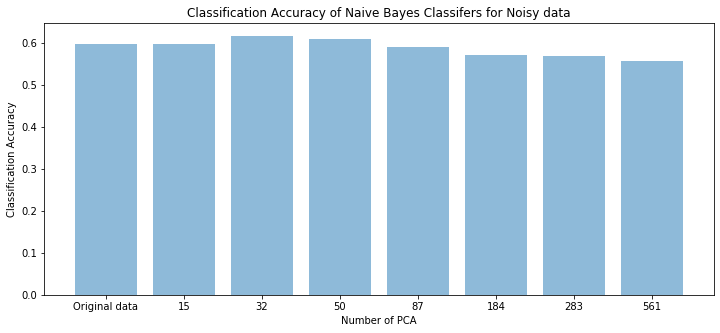

In [33]:
# 3a. comparison of classification accuracy of eight Naive Bayes classifiers on the test set
# and visualisation of their performance using a bar graph

plt.figure(figsize=(12,5))
objects = ('Original data', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))

plt.bar(y_pos, accuracies_noise, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('Classification Accuracy')
plt.title('Classification Accuracy of Naive Bayes Classifers for Noisy data')

plt.show()

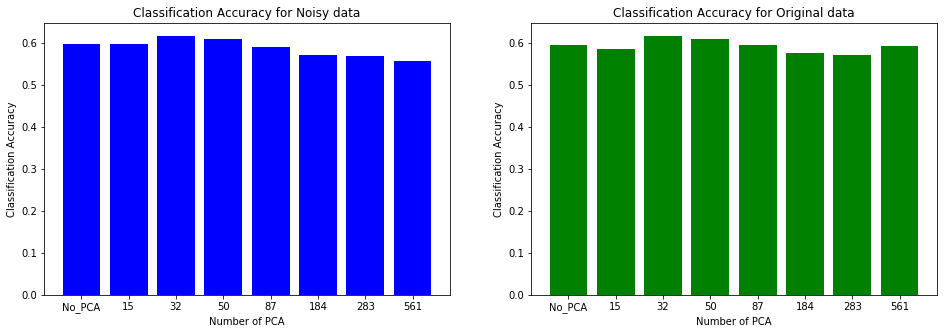

In [34]:
# 3a. comparison of classification accuracy of eight Naive Bayes classifiers on the test set
# and visualisation of their performance using a bar graph
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
objects = ('No_PCA', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))
plt.bar(y_pos, accuracies_noise, align='center', alpha=1, color= 'blue', label = 'Noisy data')
plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('Classification Accuracy')
# plt.legend()
plt.title('Classification Accuracy for Noisy data');

plt.subplot(1,2,2)
objects = ('No_PCA', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))
plt.bar(y_pos, accuracies, align='center', alpha=1, color= 'green', label = 'Original data')
plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('Classification Accuracy')
# plt.legend()
plt.title('Classification Accuracy for Original data');

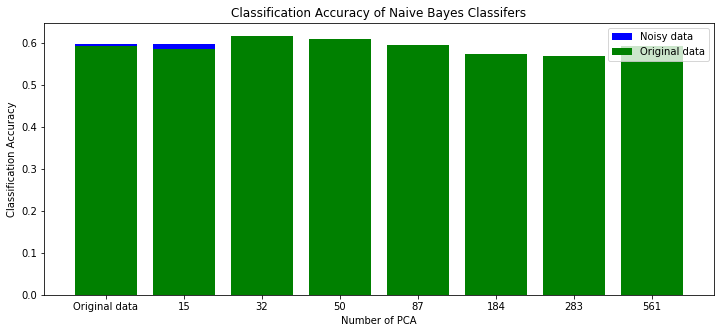

In [35]:
# 3a. comparison of classification accuracy of eight Naive Bayes classifiers on the test set
# and visualisation of their performance using a bar graph

# fig, ax = plt.subplots()
plt.figure(figsize=(12,5))
objects = ('Original data', k1, k2, k3, k4, k5, k6, k7)
y_pos = np.arange(len(objects))

plt.bar(y_pos, accuracies_noise, align='center', alpha=1, color= 'blue', label = 'Noisy data')
plt.bar(y_pos, accuracies, align='center', alpha=1, color= 'green', label = 'Original data')

plt.xticks(y_pos, objects)
plt.xlabel('Number of PCA')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.title('Classification Accuracy of Naive Bayes Classifers');

#### 3a Comparison results:

Regardless the fact that more PCA are required to represent noisy data, the final performance of Nayiev Bayes classifiers on noisy CatDog subset are almost similar to results for original data when the same range of PCA components have been studied.

### Multiclass classification using the original CIFAR-10 dataset (all 10 classes)

In [36]:
def collect_data(dataset, binarisation_for_cat_dog = False):
    # x = torch.empty([len(dataset), 3, 32, 32])
    tensor_size = [len(dataset)]
    tensor_size.extend(list(dataset[0][0].shape))
    x = torch.empty(tensor_size)
    y = torch.empty(tensor_size[0])
    
    i = 0
    for image, target in dataset:
        x[i] = image
        y[i] = target
        i += 1
    if binarisation_for_cat_dog:
        y[y==3]=0
        y[y==5]=1
        
    return x, y

def convert_data_to_numpy_and_reshape(x,y):
    # Data reshaping for PCA
    x = x.numpy() 
    y = y.numpy()

    # vectorizing each image into single vector with lenth 3*32*32 = 3072
    x = x.reshape(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])    
    return x, y

def transform_data_pca(x_train, x_test, n_components, svd_solver = 'randomized', random_state = UCard_number):
    pca_model = PCA(n_components = n_components, svd_solver = 'randomized', whiten = True, random_state = UCard_number)
    x_train_pca_done = pca_model.fit_transform(x_train)
    x_test_pca_done = pca_model.transform(x_test)
    return x_train_pca_done, x_test_pca_done

In [37]:
# Collecting x and y from dataset tuples
x_train_all, y_train_all = collect_data(trainset, binarisation_for_cat_dog = False)
x_test_all, y_test_all = collect_data(testset, binarisation_for_cat_dog = False)

# Data reshaping for PCA

x_train_pca_all, y_train_noi = convert_data_to_numpy_and_reshape(x_train_all, y_train_all)
x_test_pca_all, y_test_all = convert_data_to_numpy_and_reshape(x_test_all, y_test_all)

In [38]:
def train_test_classifer(x_train, y_train, x_test, y_test, model = 'naive_baeyes', scaling = False):
    if scaling == True:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    if model == 'naive_baeyes':
        classifier = MultinomialNB()
    elif model == 'logistic':
        classifier = LogisticRegression(solver = 'liblinear', multi_class='auto')
    elif model == 'logistic_0':
        classifier = LogisticRegression(solver = 'liblinear', multi_class='auto', max_iter=10)
    else:
        print('Ths function has only "gaussian" and "logistic" option')
    
    startTime_train = datetime.now()    
    classifier.fit(x_train, y_train)
    train_time = datetime.now() - startTime_train
    
    startTime_test = datetime.now() 
    predicted_labels = classifier.predict(x_test)
    test_time = datetime.now() - startTime_test

    accuracy = accuracy_score(y_test, predicted_labels)
    
    return predicted_labels, accuracy, train_time.total_seconds(), test_time.total_seconds()

In [39]:
# 3b - for the current task it makes sence to choose number of PCA components that provided
# the best results for original not-noisy data (32 for the best accuracy and 87 for 90% variance capture) 
# for consistency and further comparison and 1643 PCA components 
# that are almost of reasonable size and capture 90% variance of the noisy data

k1_all = 32 # the best choice from fitting original data
k2_all = 87 # captures 90% variance of original data and good results
k3_all = 184 # captures 90% variance of noisy data
range_k_all_models = [0, k1_all, k2_all, k3_all]
range_k_all_models

[0, 32, 87, 184]

In [40]:
%%time
# 3b and 3c - training of 9 models
nine_models_comparison = {}
accuracies_all_model = []
train_times = []
test_times = []
model_names = []

models = ['naive_baeyes', 'logistic']
range_k_all_models = [k1_all, k2_all, k3_all]

# k=0 for Naive Bayes
y_pred, accuracy, train_time, test_time = train_test_classifer(x_train_pca_all, y_train_all, 
                                                               x_test_pca_all, y_test_all, model = 'naive_baeyes', scaling = True)
model_name = "naive_baeyes_0"
nine_models_comparison[model_name] = {}
nine_models_comparison[model_name]['accuracy'] = accuracy
nine_models_comparison[model_name]['train_time']  = train_time
nine_models_comparison[model_name]['test_time']  = test_time
nine_models_comparison[model_name]['y_test_pred']  = y_pred

accuracies_all_model.append(accuracy)
train_times.append(train_time)
test_times.append(test_time)
model_names.append(model_name)

for model in models:
    for k in range_k_all_models:
        x_train_pca_all_done, x_test_all_pca_done = transform_data_pca(x_train_pca_all, x_test_pca_all, n_components= k)
        y_pred, accuracy, train_time, test_time = train_test_classifer(x_train_pca_all_done, y_train_all, 
                                                                       x_test_all_pca_done, y_test_all, model = model, scaling = True)
        model_name = model + '_' + str(k)
        print(model_name)
        nine_models_comparison[model_name] = {}
        nine_models_comparison[model_name]['accuracy'] = accuracy
        nine_models_comparison[model_name]['train_time']  = train_time
        nine_models_comparison[model_name]['test_time']  = test_time
        nine_models_comparison[model_name]['y_test_pred']  = y_pred
    
        accuracies_all_model.append(accuracy)
        train_times.append(train_time)
        test_times.append(test_time)
        model_names.append(model_name)

naive_baeyes_32
naive_baeyes_87
naive_baeyes_184
logistic_32
logistic_87
logistic_184
CPU times: user 2min 26s, sys: 28 s, total: 2min 54s
Wall time: 2min 35s


In [41]:
# Note: neural network architecture and the code for its traing were taken 
# almost unchanged from our previous lab works and jupyter notebook solutions
# kindly provided by Haiping Lu  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# training CNN

startTime_train_NN = datetime.now()    

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

train_time_NN = datetime.now() - startTime_train_NN
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

# Testing NN
train_time_nn = 0
test_time_nn = 0
correct = 0
total = 0
y_pred_NN = []

startTime_testNN = datetime.now() 

with torch.no_grad():
    for data in testloader:
        images, labels = data 
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
#         test_time_batch = datetime.now() - startTime_test
#         test_time_nn += test_time_batch.total_seconds()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred_NN.extend(predicted.numpy())
        
test_time_NN = datetime.now() - startTime_testNN       
model_name= 'NN_0'
nine_models_comparison[model_name]={}
nine_models_comparison[model_name]['accuracy'] = correct / total

# nine_models_comparison[model_name]['accuracy'] = accuracy
nine_models_comparison[model_name]['train_time']  = train_time_NN.total_seconds()
nine_models_comparison[model_name]['test_time']  = test_time_NN.total_seconds()
nine_models_comparison[model_name]['y_test_pred']  = np.array(y_pred_NN)
    
accuracies_all_model.append(accuracy)
train_times.append(train_time_NN.total_seconds())
test_times.append(test_time_NN.total_seconds())
model_names.append(model_name)

[1,  2000] loss: 2.182
[1,  4000] loss: 1.757
[1,  6000] loss: 1.582
[2,  2000] loss: 1.463
[2,  4000] loss: 1.389
[2,  6000] loss: 1.365


In [43]:
len(model_names)

8

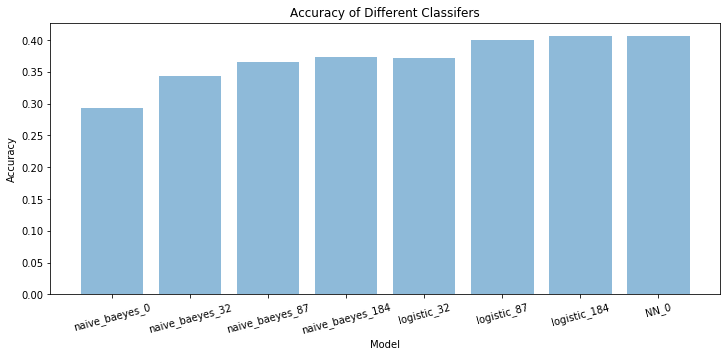

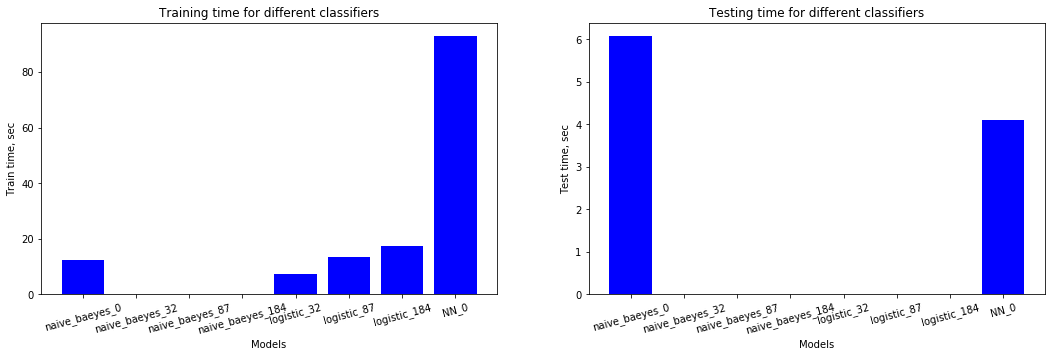

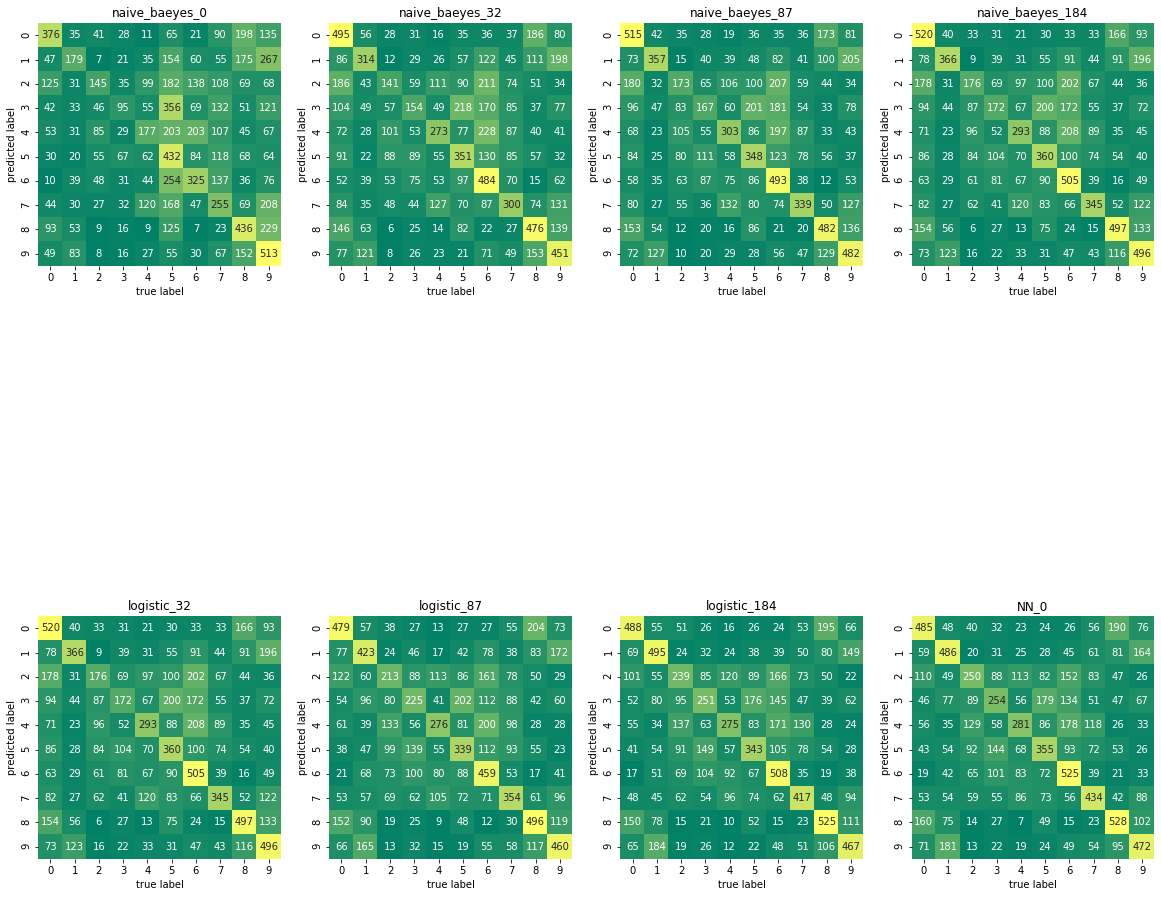

In [44]:
# 3d Comparison of Accuracies:

plt.figure(figsize=(12,5))
objects = model_names
y_pos = np.arange(len(objects))
plt.bar(y_pos, accuracies_all_model, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=15)  
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifers');

# 3d Comparison of Training and Testing times 
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
objects = model_names
y_pos = np.arange(len(objects))
plt.bar(y_pos, train_times, align='center', alpha=1, color= 'blue', label = 'Training')
plt.xticks(y_pos, objects, rotation=15)
plt.xlabel('Models')
plt.ylabel('Train time, sec')
plt.title('Training time for different classifiers');

plt.subplot(1,2,2)
objects = model_names
y_pos = np.arange(len(objects))
plt.bar(y_pos, test_times, align='center', alpha=1, color= 'blue', label = 'Testing')
plt.xticks(y_pos, objects, rotation=15)
plt.xlabel('Models')
plt.ylabel('Test time, sec')
# plt.legend()
plt.title('Testing time for different classifiers');

# 3e Confusion matrices

if len(model_names) == 8:
    fig, axes1 = plt.subplots(2,4,figsize=(20,20), squeeze = False)
    for i, model in enumerate(model_names):
        if i <4:
            y_test_predicted = nine_models_comparison[model]['y_test_pred']
            conf_matrix = confusion_matrix(y_test_all, y_test_predicted)
            sns.heatmap(conf_matrix, annot=True, cbar=False, square=True, fmt='d', cmap= 'summer', ax = axes1[0][i])
            axes1[0][i].set_xlabel('true label')
            axes1[0][i].set_ylabel('predicted label')
            axes1[0][i].set_title(model)
        
        else:
            sns.heatmap(conf_matrix, annot=True, cbar=False, square=True, fmt='d', cmap= 'summer', ax= axes1[1][i-4])
            axes1[1][i-4].set_xlabel('true label')
            axes1[1][i-4].set_ylabel('predicted label')
            axes1[1][i-4].set_title(model)
            y_test_predicted = nine_models_comparison[model]['y_test_pred']
            conf_matrix = confusion_matrix(y_test_all, y_test_predicted)

if len(model_names) == 9:
    fig, axes1 = plt.subplots(3,3,figsize=(20,20), squeeze = False)
    for i, model in enumerate(model_names):
        if i <3:
            y_test_predicted = nine_models_comparison[model]['y_test_pred']
            conf_matrix = confusion_matrix(y_test_all, y_test_predicted)
            sns.heatmap(conf_matrix, annot=True, cbar=False, square=True, fmt='d', cmap= 'summer', ax = axes1[0][i])
            axes1[0][i].set_xlabel('true label')
            axes1[0][i].set_ylabel('predicted label')
            axes1[0][i].set_title(model)
        elif (i>=3) & (i<6):
            y_test_predicted = nine_models_comparison[model]['y_test_pred']
            conf_matrix = confusion_matrix(y_test_all, y_test_predicted)
            sns.heatmap(conf_matrix, annot=True, cbar=False, square=True, fmt='d', cmap= 'summer', ax = axes1[1][i-3])
            axes1[1][i-3].set_xlabel('true label')
            axes1[1][i-3].set_ylabel('predicted label')
            axes1[1][i-3].set_title(model)
        else:
            sns.heatmap(conf_matrix, annot=True, cbar=False, square=True, fmt='d', cmap= 'summer', ax= axes1[2][i-6])
            axes1[2][i-6].set_xlabel('true label')
            axes1[2][i-6].set_ylabel('predicted label')
            axes1[2][i-6].set_title(model)
            y_test_predicted = nine_models_comparison[model]['y_test_pred']
            conf_matrix = confusion_matrix(y_test_all, y_test_predicted);

**Interesting observations:**

1. Using of PCA transformation of a data set obvioulsly speeds up the process of model training and convergence. Surprisingly, it was especcialy crucial not for the convolutional neural network, but for logistic regression.
In the current task, fitting of logistic to original data appeared to be to too slow, had no convergence and failed to be completed in a reasonable time. However, there were no problem with the same model but PCA transformed data.

2. As it was expected, the proposed Convolutional neural network demonstrated the highest accuracy for Cifar10 dataset classification task but with suprisingly short execution time. However, such performance is still not optimal from the view point of balance of accuracy and training time. On the contrary, the Naieve Bayes classifiers had no more than 5-10% lover accuracy but provided their results 5 times faster. 

3. Considering further implementation, none of the studied model had reached accuracy of at least 80% and therefore could be stated as the right model for that paticular dataset modelling. Confusion matrix for all the models are also not so promissing. So to reach good results, some crucial improvemnets for the neural network should be done, or some other machine learning algorithm should be tested. At the same time, the loss for CNN is quite high and can be improved by more iterartions.

### Part 4: Multiclass classification & Denoising Autoencoder 

In [46]:
batchSize=8

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)

noise_scale = 0.2 # we can choose any scale value between 0.2 and 0.5

transform_add_noise = transforms.Compose([transforms.ToTensor(),
                                          transforms.Lambda(lambda x: add_noise_img(x, noise_scale)), 
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset_with_noise = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform = transform_add_noise)

trainloader_with_noise = torch.utils.data.DataLoader(trainset_with_noise, batch_size = batchSize,
                                          shuffle=False, num_workers=2)

testset_with_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform = transform_add_noise)

testloader_with_noise = torch.utils.data.DataLoader(testset_with_noise, batch_size = batchSize,
                                          shuffle=False, num_workers=2)

In [47]:
# 4a Modifying Autoencoder from Lab 7

class Autoencoder_Modified(nn.Module):
    def __init__(self):
        super(Autoencoder_Modified, self).__init__()
        self.encoder = nn.Sequential(
            # 3 input image channel, 16 output channel, 3x3 square convolution
           
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [48]:
# 4b training with noisy images but comparing to clean ones

def train_CNN(batchSize, learning_rate, max_epochs):
    
    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose an optimiser
    optimizer = torch.optim.SGD(myAE_modified.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Storage
    outputs = []
    
    # Collect originial images for comparison
    batch_tensor_size = [batchSize]
    batch_tensor_size.extend(list(trainset[0][0].shape))

    for epoch in range(max_epochs):
    
        for batch_index, data in enumerate(trainloader_with_noise,0):
            images_with_noise, labels = data
        
        # Collect corresponding original images
            original_images = torch.empty(batch_tensor_size)
            for j in range(batchSize):
                original_images[j] = trainset[batch_index * batchSize + j][0]
            if (batch_index % 500) ==0:
                print(batch_index)
            
            optimizer.zero_grad()
            output = myAE_modified(images_with_noise)
        
            loss = criterion(output, original_images)
            loss.backward()
            optimizer.step()            
        if (epoch % 2) == 0:
            print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
            print(loss)
        outputs.append((epoch, images_with_noise, output))
    return outputs

In [49]:
# Hyperparameters for training

learning_rate = 0.05
max_epochs = 2

myAE_modified = Autoencoder_Modified()

outputs = train_CNN(batchSize, learning_rate, max_epochs)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
Epoch:1, Loss:0.2508
tensor(0.2508, grad_fn=<MseLossBackward>)
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [74]:
# 4c training and collecting reconstructed images

def test_and_reconstruct(testloader_with_noise, testset, batchSize):
    reconstruction_errors =[]
    reconstructed_images = []
    criterion = nn.MSELoss() 

    for batch_index, data in enumerate(testloader_with_noise,0):
        images_with_noise, labels = data
        output = myAE_modified(images_with_noise)
    
        for j in range(batchSize):
            reconstructed = output[j].detach()
#             # feeding noisy images and compute reconstruction errors on original clean images
            original = trainset[batch_index * batchSize + j][0]
            error = criterion(reconstructed, original)
            reconstruction_errors.append(error.detach().numpy())
            reconstructed_images.append(reconstructed)
        
        if (batch_index % 250) ==0:
            print(batch_index)
            
    return reconstruction_errors, reconstructed_images

In [75]:
%time
reconstruction_errors, reconstructed_images = test_and_reconstruct(testloader_with_noise, testset, batchSize)
reconstruction_errors = np.array(reconstruction_errors).flatten()

CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 21 µs
0
250
500
750
1000


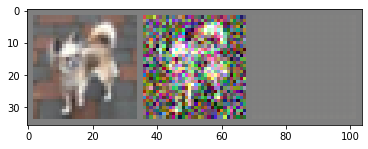

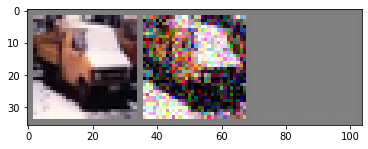

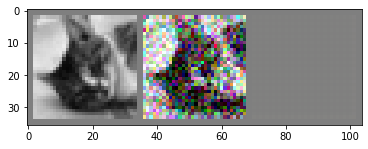

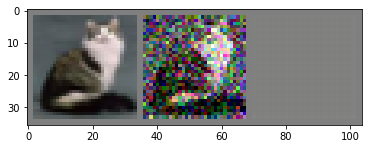

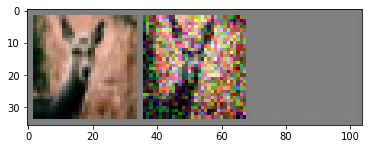

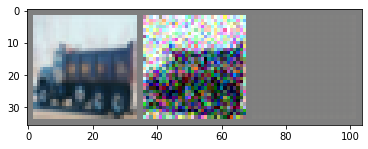

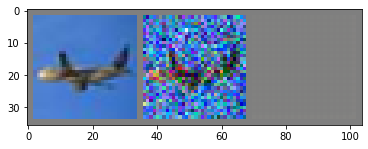

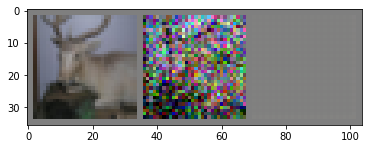

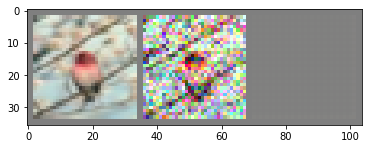

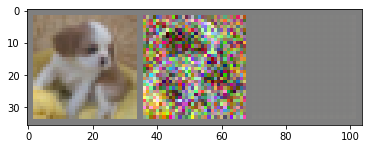

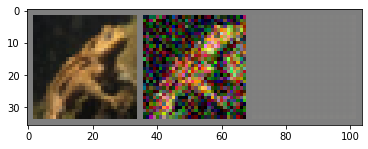

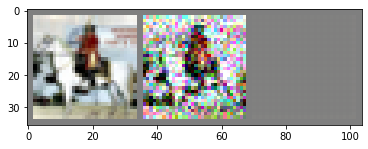

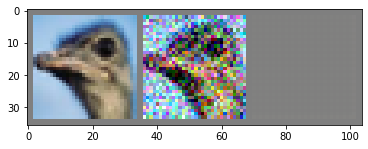

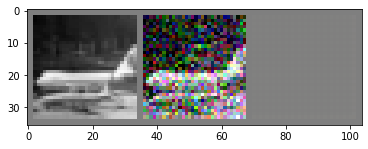

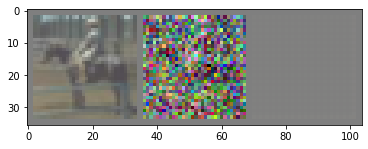

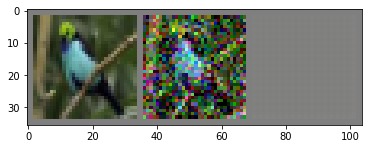

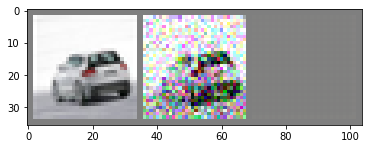

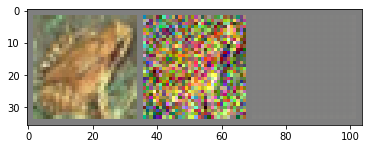

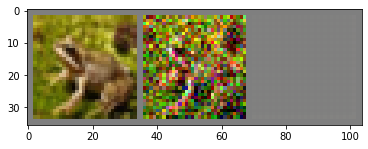

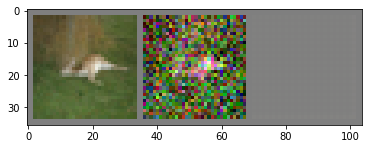

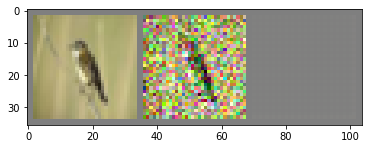

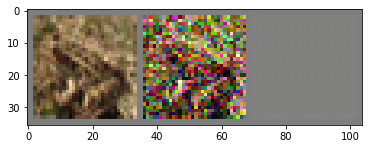

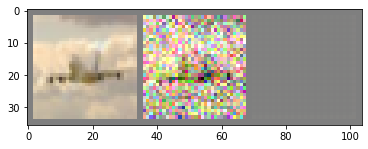

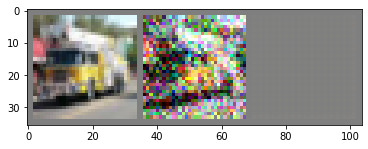

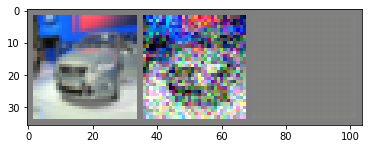

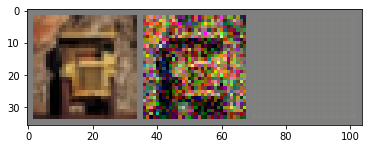

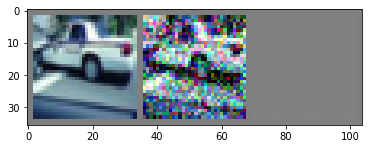

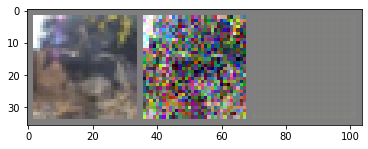

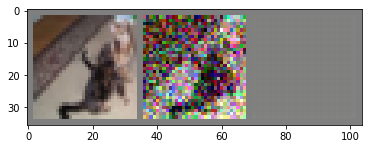

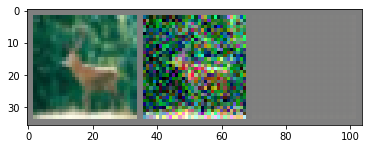

In [79]:
# 4c finding largest errors
heapq_values = heapq.nlargest(30, reconstruction_errors) 
indices_worst_reconstruction  = heapq.nlargest(30, range(len(reconstruction_errors)), reconstruction_errors.take)

# plot 30 worst pairs
for index in indices_worst_reconstruction:
    original_noisy_reconstructed = [testset[index][0], testset_with_noise[index][0], reconstructed_images[index].detach()] 
    imshow(torchvision.utils.make_grid(original_noisy_reconstructed))

In [ ]:
mean_error_default_model = reconstruction_errors.mean()
reconstructed_images_default_model = reconstructed_images

In [ ]:
# 4d varying two hyperparameters 
max_epochs_additional = [5, 10]

learning_rate = 0.05
mean_error_epochs = [mean_error_default_model]
reconstructed_img_epochs = [reconstructed_images_default_model]
for epoch in max_epochs_additional:
    
    myAE_modified = Autoencoder_Modified()
    outputs = train_CNN(batchSize, learning_rate, epoch)
    reconstruction_errors, reconstructed_images = test_and_reconstruct(testloader_with_noise, testset, batchSize)
    reconstruction_errors = np.array(reconstruction_errors).flatten()
    mean_error = reconstruction_errors.mean()
    mean_error_epochs.append(mean_error)
    reconstructed_img_epochs.append(reconstructed_images)

In [ ]:
learning_rate_additional = [0.01, 0.1]

max_epochs = 2
mean_error_lr = [mean_error_default_model]
reconstructed_img_lr = [reconstructed_images_default_model]

for lr in learning_rate_additional:
    myAE_modified = Autoencoder_Modified()
    outputs = train_CNN(batchSize, lr, max_epochs)
    reconstruction_errors, reconstructed_images = test_and_reconstruct(testloader_with_noise, testset, batchSize)
    reconstruction_errors = np.array(reconstruction_errors).flatten()
    mean_error = reconstruction_errors.mean()
    mean_error_lr.append(mean_error)
    reconstructed_img_lr.append(reconstructed_images)

In [ ]:
# Comparison of Autoencoder performance under different hyperparameters
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
objects = [2, 5, 10]
y_pos = np.arange(len(objects))
plt.bar(y_pos, mean_error_epochs, align='center', alpha=1, color= 'blue', label = 'Training')
plt.xticks(y_pos, objects)
plt.xlabel('Number of training epochs')
plt.ylabel('Mean reconstruction error')
plt.title('Learning rate = 0.05');

plt.subplot(1,2,2)
objects = [0.01, 0.05, 0.1]
mean_error_lr_sorted = [mean_error_lr[1],mean_error_lr[0], mean_error_lr[2]]
y_pos = np.arange(len(objects))
plt.bar(y_pos, mean_error_lr_sorted, align='center', alpha=1, color= 'blue', label = 'Testing')
plt.xticks(y_pos, objects)
plt.xlabel('Learning rate')
plt.ylabel('Mean reconstruction error')
# plt.legend()
plt.title('Traing epochs = 2');